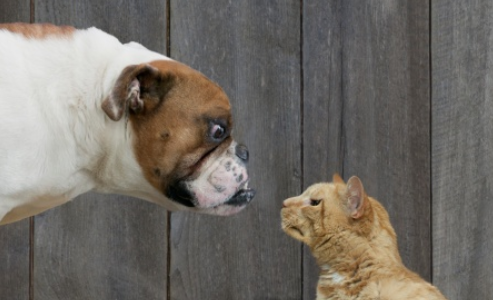

MNIST 데이터셋은 이미지 패턴이 비교적 단순하며 흑백의 색상을 가지고, 이미지가 모두 같은 크기를 가지기 때문에 상대적으로 쉬운 문제로 알려져 있습니다.

하지만 현실의 이미지 분류 문제는 이와 달리 더 복잡한 패턴을 가지거나 다양한 색상을 가지고, 또한 이미지의 크기가 달라질 수 있습니다.

이번 페이지에서는 잘 알려진 이미지 분류 문제인 Kaggle Dogs Vs. Cats 데이터셋을 살펴보고, Neural Network를 구성하고 훈련시켜서, 정확도를 확인하는 과정에 대해 순서대로 소개합니다.

# 1.Kaggle Dogs Vs. Cats 데이터셋 준비하기


Kaggle (캐글)은 데이터 사이언스와 머신러닝 경진대회를 위한 플랫폼입니다.
머신러닝 학습과 해결, 경쟁을 위한 다양한 데이터셋을 제공하며, 2017년 3월 Google에 인수되었습니다.
Dogs Vs. Cats 데이터셋은 Kaggle에서 다루었던 Challenge 중 하나였습니다.
현재 이 Challenge는 종료되었습니다.



In [2]:
!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
-O /tmp/cats_and_dogs_filtered.zip

--2021-08-07 09:49:49--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.128, 74.125.31.128, 74.125.139.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   172MB/s    in 0.4s    

2021-08-07 09:49:49 (172 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



# 2.개와 고양이 데이터셋 다운로드 하고 압축 풀기

In [4]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
# 기본 경로
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# 훈련에 사용되는 고양이/개 이미지 경로
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(train_cats_dir)
print(train_dogs_dir)

# 테스트에 사용되는 고양이/개 이미지 경로
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(validation_cats_dir)
print(validation_dogs_dir)

/tmp/cats_and_dogs_filtered/train/cats
/tmp/cats_and_dogs_filtered/train/dogs
/tmp/cats_and_dogs_filtered/validation/cats
/tmp/cats_and_dogs_filtered/validation/dogs


# 3.Kaggle Dogs Vs. Cats 데이터셋 살펴보기

In [9]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:5])
print(train_dog_fnames[:5])

['cat.507.jpg', 'cat.569.jpg', 'cat.167.jpg', 'cat.101.jpg', 'cat.499.jpg']
['dog.838.jpg', 'dog.235.jpg', 'dog.439.jpg', 'dog.543.jpg', 'dog.344.jpg']


In [10]:
print('Total training cat images :', len(os.listdir(train_cats_dir)))
print('Total training dog images :', len(os.listdir(train_dogs_dir)))

print('Total validation cat images :', len(os.listdir(validation_cats_dir)))
print('Total validation dog images :', len(os.listdir(validation_dogs_dir)))

Total training cat images : 1000
Total training dog images : 1000
Total validation cat images : 500
Total validation dog images : 500


# 4.이미지 확인하기

Matplotlib 라이브러리를 이용해서 이미지를 출력해보면, 데이터셋에 아래와 같은 이미지들이 포함되어 있음을 알 수 있습니다.

주피터 노트북에서 파이썬 코드를 실행할 때 %matplotlib inline를 써야할 때가 있는데, 

이는 주피터 노트북을 실행한 브라우저에서 바로 그림을 볼 수 있게끔 만드는 것.

즉, 브라우저 내부(inline)에 바로 그려지도록 해주는 코드이다.

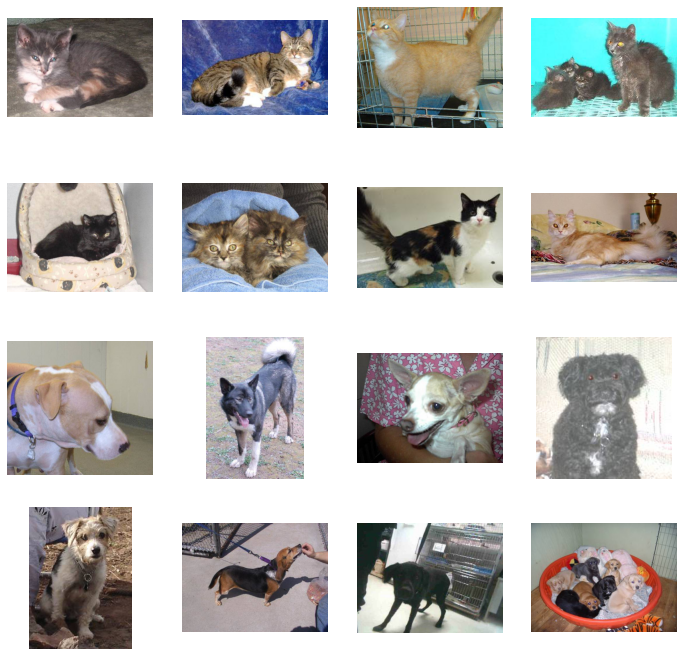

In [11]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows, ncols = 4, 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[ pic_index-8:pic_index]]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[ pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# 5.모델 구성하기

이제 TensorFlow를 이용해서 합성곱 신경망의 모델을 구성합니다.

summary() 메서드를 이용해서 신경망의 구조를 확인할 수 있습니다.

tf.keras.models 모듈의 Sequential 클래스를 사용해서 인공신경망의 각 층을 순서대로 쌓을 수 있습니다.

add() 메서드를 이용해서 합성곱 층 Conv2D와 Max pooling 층 MaxPooling2D를 반복해서 구성합니다.


첫번째 Conv2D 층의 첫번째 인자 16은 filters 값입니다.

합성곱 연산에서 사용되는 필터 (filter)는 이미지에서 특징 (feature)을 분리해내는 기능을 합니다.

filters의 값은 합성곱에 사용되는 필터의 종류 (개수)이며, 출력 공간의 차원 (깊이)을 결정합니다.

두번째 인자 (3, 3)은 kernel_size 값입니다.
kernel_size는 합성곱에 사용되는 필터 (=커널)의 크기입니다.
아래와 같은 3×3 크기의 필터가 사용되며, 합성곱 연산이 이루어지고 나면 이미지는 (150, 150) 크기에서 (148, 148)이 됩니다.

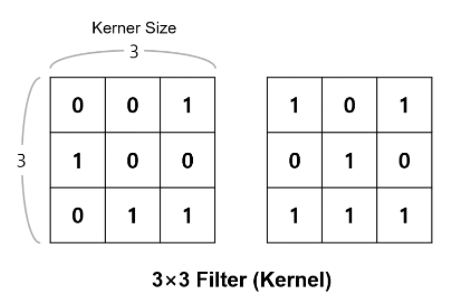

활성화함수 (Activation function)는 ‘relu’로 지정하고,

입력 데이터의 형태 (input_shape)는 아래와 같이 150픽셀*150픽셀 3채널(컬러이미지) 이미지 하나의 형태에 해당하는 (150, 150, 3)로 설정합니다.

풀링 (Pooling)은 합성곱에 의해 얻어진 Feature map으로부터 값을 샘플링해서 정보를 압축하는 과정을 의미합니다.

맥스풀링 (Max-pooling)은 특정 영역에서 가장 큰 값을 샘플링하는 풀링 방식이며,

예제에서는 풀링 필터의 크기를 2×2 영역으로 설정했습니다.

strides는 풀링 필터를 이동시키는 간격을 의미합니다.

strides를 지정해주지 않으면 (None), 풀링 필터의 크기와 같아서 영역의 오버랩 없이 풀링이 이루어집니다.

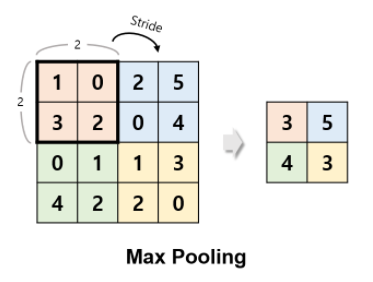

따라서 풀링이 이루어지고 나면, (148, 148) 크기의 이미지는 (74, 74) 크기가 됩니다.

summary() 메서드를 이용해서 지금까지 구성한 신경망에 대한 정보를 출력할 수 있습니다.

합성곱 층에 이어 뒷부분에는 분류를 담당하는 Dense 층 (Fully-connected layer)을 세 개 추가합니다.

MLP구조에서 활성함수는  relu를 사용하고 
마지막 출력층 노드의 개수는 1개로 하고 2종류중 분류를 위해 ‘sigmoid’ 활성화함수를 사용합니다.

In [13]:
import tensorflow as tf


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

지금까지 구성한 신경망의 구조를 그림으로 나타내면 아래와 같습니다.

이러한 합성곱, 풀링 층은 특성 추출 (Feature Extraction)을 담당하며, 전체 합성곱 신경망의 앞부분을 구성합니다.

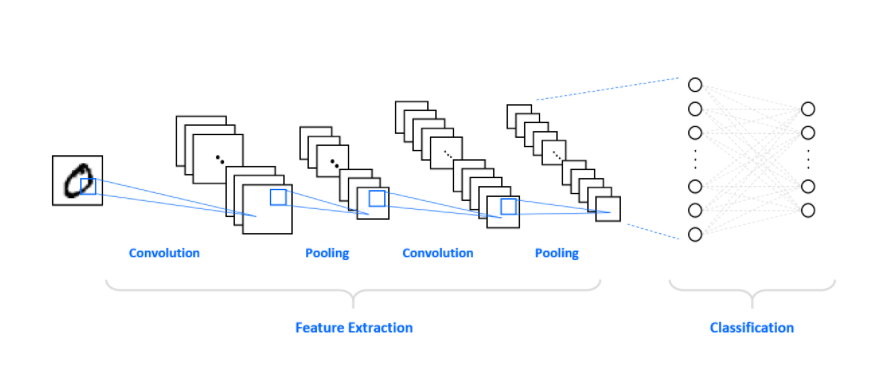

# 6.모델 컴파일하기

모델 컴파일 단계에서는 compile() 메서드를 이용해서 손실 함수 (loss function)와 옵티마이저 (optimizer)를 지정합니다.

고양이와 개 이미지 분류하기 손실 함수로 ‘binary_crossentropy’를 사용했습니다.

출력층의 활성화함수로 ‘sigmoid’를 사용했고, 이는 0과 1 두 가지로 분류되는 ‘binary’ 분류 문제에 적합하기 때문입니다.

또한, 옵티마이저로는 RMSprop을 사용했습니다.

RMSprop (Root Mean Square Propagation) Algorithm은 훈련 과정 중에 학습률을 적절하게 변화시킵니다.



In [15]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
            loss='binary_crossentropy',
            metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# 7.이미지 데이터 전처리하기

훈련을 진행하기 전, tf.keras.preprocessing.image 모듈의 ImageDataGenerator 클래스를 이용해서 데이터 전처리를 진행합니다.

우선 ImageDataGenerator 객체의 rescale 파라미터를 이용해서 모든 데이터를 255로 나누어준 다음,

flow_from_directory() 메서드를 이용해서 훈련과 테스트에 사용될 이미지 데이터를 만듭니다.

첫번째 인자로 이미지들이 위치한 경로를 입력하고, batch_size, class_mode를 지정합니다.

target_size에 맞춰서 이미지의 크기가 조절됩니다.



In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                  batch_size=20,
                                                  class_mode='binary',
                                                  target_size=(150, 150))
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                       batch_size=20,
                                                       class_mode  = 'binary',
                                                       target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# 8.모델 훈련하기

fit() 메서드는 앞에서 구성한 Neural Network 모델을 훈련합니다.

훈련과 테스트를 위한 데이터셋인 train_generator, validation_generator를 입력합니다.

epochs는 데이터셋을 한 번 훈련하는 과정을 의미합니다.

steps_per_epoch는 한 번의 에포크 (epoch)에서 훈련에 사용할 배치 (batch)의 개수를 지정합니다.

validation_steps는 한 번의 에포크가 끝날 때, 테스트에 사용되는 배치 (batch)의 개수를 지정합니다.

아래와 같은 훈련 과정을 확인할 수 있습니다.

In [17]:
#epochs 횟수만큼 학습하기
#다양한 하이퍼파라미터들 꼭 기억하세요
#학습 시간이 10분이상 걸림(쉬었다 오세요)
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100,
                    #epochs=100,
                    epochs=3,
                    validation_steps=50,
                    verbose=2)

Epoch 1/3
100/100 - 59s - loss: 0.8059 - accuracy: 0.5470 - val_loss: 0.6628 - val_accuracy: 0.6620
Epoch 2/3
100/100 - 58s - loss: 0.6455 - accuracy: 0.6535 - val_loss: 0.6139 - val_accuracy: 0.6790
Epoch 3/3
100/100 - 58s - loss: 0.5563 - accuracy: 0.7195 - val_loss: 0.6078 - val_accuracy: 0.6810


# 9.정확도와 손실 확인하기

Matplotlib 라이브러리를 이용해서 훈련 과정에서 에포크에 따른 정확도와 손실을 출력합니다.

아래와 같은 이미지가 출력됩니다.

20회 에포크에서 훈련 정확도는 1.0에 근접한 반면, 테스트의 정확도는 100회 훈련이 끝나도 0.7 수준에 머물고 있습니다.

이러한 현상을 과적합 (Overfitting)이라고 합니다.

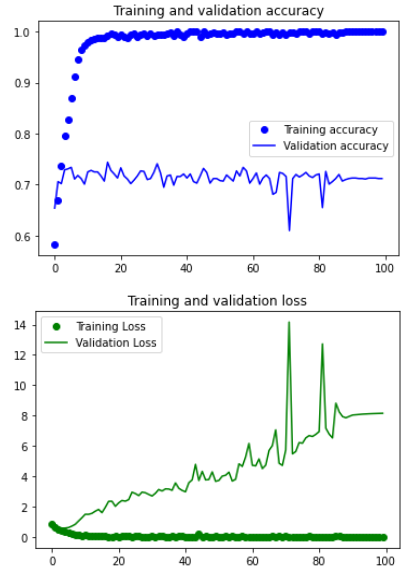

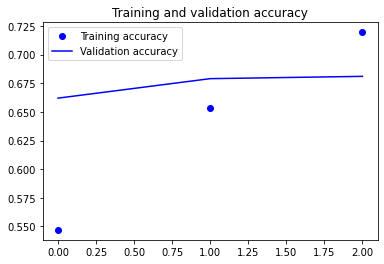

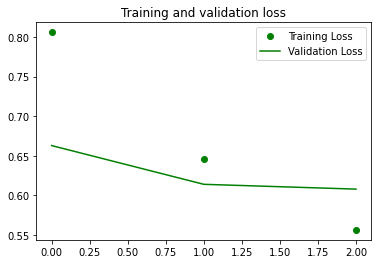

In [18]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 10.테스트 이미지 분류하기

파일선택 버튼을 눌러서 PC의 파일 선택하기

In [29]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():

  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))

  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  print(classes[0])

  if classes[0]>0:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")



Saving cat.2000.jpg to cat.2000 (2).jpg
[5.885557e-33]
cat.2000.jpg is a dog


# 11.숙제 (업로드한 사진 이미지 화면에 보여주기)

In [32]:
#위 10번 소스에서 아래 코드 2줄을 추가로 입력하여 업로드한 이미지를 화면에 보여주세요

#import matplotlib.pyplot as plt
#  plt.imshow(이미지)
